## Satellite Imagery and Analysis with PACE OCI
This script will load in a satellite dataset and use various techniques to explore and plot the images. On Thursday, we will use the different parts of this script to answer some science questions about clouds, aerosols, land, and ocean in smaller groups.

There are two new libraries here, besides <i>numpy</i> and <i>matplotlib</i> that we used earlier:
- <i>NETCDF4</i> is a set of functions that open and parse satellite datasets.
- <i>cartopy</i> takes a latitude and longitude grid and helps to project satellite data onto the Earth's surface. We will use this to see where the satellite was where the image was taken and identify any land features.

Like before, everything needs to be run in sequence. Use <b>Shift + Return</b> to run a cell.

In [1]:
#load the libraries
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm,colors
from netCDF4 import Dataset
import cartopy
import cartopy.crs as ccrs

print("Libraries loaded.")

#degrees to radians conversion
dtor = np.pi/180.

#conversion from radiance to reflectance
def reflectance(rad,sza,f0):
    '''
    INPUT
    rad - 4D float array, radiances at TOA (W m-2 um-1 sr-1)
    sza - 2D float array, solar zenith angle (degrees)
    f0 - 2D float array, solar irradiance at TOA (W m-2 um-1 sr-1)
    OUTPUT
    refl - 4D float array, reflectances at TOA (arbitrary units)
    '''

    global dtor
    
    #calculate the size of rad
    rsh = rad.shape

    #allocate the reflectance array and cycle over tilt value and wavelength
    refl = np.copy(rad)*0
    for wv in range(rsh[-1]):

        refl[:,:,:,wv] = np.pi*rad[:,:,:,wv]/(np.cos(sza*dtor)*f0[:,wv])

    return refl

Libraries loaded.


# Loading an image
Let's use the netCDF4 library to open the satellite data for the PACE Ocean Color Instrument (OCI). The <i>Dataset</i> function needs the path to the dataset, which starts with a <b>./</b> to tell Jupyter that the data is in the same folder as this script. The "r" at the end tells Dataset to open the file for reading only.

Now, <i>oci_data</i> is a netCDF dataset. If we run <i>oci_data.groups</i>, we can see what is in the file.

In [75]:
#load the image
oci_data = Dataset("../Thursday/PACE_OCI.20240918T171411.L1C.V3.5km.nc",'r')
oci_data.groups

{'sensor_views_bands': <class 'netCDF4.Group'>
 group /sensor_views_bands:
     dimensions(sizes): 
     variables(dimensions): float32 sensor_view_angle(number_of_views), float32 intensity_wavelength(number_of_views, intensity_bands_per_view), float32 intensity_bandpass(number_of_views, intensity_bands_per_view), float32 intensity_f0(number_of_views, intensity_bands_per_view)
     groups: ,
 'bin_attributes': <class 'netCDF4.Group'>
 group /bin_attributes:
     dimensions(sizes): 
     variables(dimensions): float64 nadir_view_time(bins_along_track), float64 view_time_offsets(bins_along_track, bins_across_track, number_of_views)
     groups: ,
 'geolocation_data': <class 'netCDF4.Group'>
 group /geolocation_data:
     dimensions(sizes): 
     variables(dimensions): float32 latitude(bins_along_track, bins_across_track), float32 longitude(bins_along_track, bins_across_track), int16 height(bins_along_track, bins_across_track), int16 height_stdev(bins_along_track, bins_across_track), int1

There is a lot of stuff in here, but some things might be familiar. The netCDF file is a <b>hierarchal dataset</b> meaning that the data is saved in folders. There are four main data folders:

 - **sensors_views_bands**: metadata for the different sampling characteristics of the instrument
 - **bin_attributes**: information about the aggregation and timing of the data fields
 - **geolocation_data**: gridded information about where the pixel is located on Earth
 - **observation_data**: geophysical products like radiance, the amount of energy from the light scattered from each target

Let's open some data fields.

In [127]:
#load in geolocation fields for latitude and longitude
lon = oci_data['/geolocation_data/longitude']

#print the attributes of longitude
print("Longitude Attributes")
print(lon.ncattrs)

#grab the lat lon datasets 
lon = lon[:].data
lat = oci_data['/geolocation_data/latitude'][:].data
grid_size = lon.shape
print(f"\nThe imagery dimensions are [x,y]: {[grid_size[1],grid_size[0]]}\n")

#load in radiance and sensor observation geometry 
#sza and f0 are the angles of the Sun relative to each pixel location on Earth and the amount of sunlight we expect at the top of the atmosphere (edge of space).
rad = oci_data['/observation_data/i']
rad_data = rad[:].data
sza = oci_data['/geolocation_data/solar_zenith_angle'][:].data
f0 = oci_data['/sensor_views_bands/intensity_f0'][:].data
rdnc = reflectance(rad_data,sza,f0)

#calculate and print where the center of the image is
center_lat = lat[int(grid_size[0]/2.),int(grid_size[1]/2.)]
center_lon = lon[int(grid_size[0]/2.),int(grid_size[1]/2.)]

print("Center Latitude:", center_lat)
print("Center Longitude:", center_lon)

Longitude Attributes
<bound method Variable.ncattrs of <class 'netCDF4.Variable'>
float32 longitude(bins_along_track, bins_across_track)
    long_name: Longitudes of bin locations
    units: degrees_east
    _FillValue: -32767.0
    valid_min: -180.0
    valid_max: 180.0
path = /geolocation_data
unlimited dimensions: 
current shape = (395, 519)
filling on>

The imagery dimensions are [x,y]: [519, 395]

Center Latitude: -22.356636
Center Longitude: -61.015205


This metadata is <b>extremely important</b>. We can see that the data is a certain 2D shape. The y-dimension represents pixels in the direction of flight (along-track). The x-dimension are pixels perpendicular to it (across-track). 

Longitude is reported in degrees and positive numbers are east of the prime meridian. Unusable pixels are given a fill value and we can expect science-quality pixels to have a +- 180 degree range. This data is also encoded in float32 precision.

We can also use a bit of logic to calculate the latitude and logitude of the center of the image. We can go back to NASA Worldview and see how well we did in choosing the dataset based on the approximate timestamp. Float your cursor over the orbit near to the data time and see in the right-hand corner what the latitude and longitude are. Hopefully you are close!

Now, let's open the radiance attributes.

In [128]:
#list the radiance attributes
rad.ncattrs

<bound method Variable.ncattrs of <class 'netCDF4.Variable'>
float32 i(bins_along_track, bins_across_track, number_of_views, intensity_bands_per_view)
    long_name: I Stokes vector component
    units: W m^-2 sr^-1 um^-1
    _FillValue: -32767.0
    valid_min: 0.0
    valid_max: 999.0
    coordinates: geolocation_data/longitude geolocation_data/latitude
path = /observation_data
unlimited dimensions: 
current shape = (395, 519, 2, 286)
filling on>

This one differs from longitude considerably. We see here that radiance is in units of watts per meter (squared) per micron per steradian (sr).

Radiance is a 4D data field (see "current shape"). The first two are along- and across-track pixel dimensions, like longitude. The last two are number of views and wavelengths per view. OCI is a <i>spectrometer</i>, meaning that it can measure Earth in many different and unique colors. 

OCI also looks at the Earth from two different angles (the 2 in the third dimension). In the northern hemisphere, it's camera tilts forward. In the southern hemisphere, it tilts backward. This is to avoid the direct and very bright reflection of the Sun off the surface of the ocean that happens near the Equator. Depending on where we are on Earth, we only have data from one of the tilts. We have to figure out which one we have.

<b>OCI views the Earth in 286 different colors</b>. Let's see what they are!

In [129]:
#load and print the wavelengths
chnl_by_view = oci_data['/sensor_views_bands/intensity_wavelength'][0,:].data
print(chnl_by_view)

[ 314.55   316.239  318.262  320.303  322.433  324.649  326.828  328.988
  331.305  333.958  336.815  339.16   341.321  343.632  346.017  348.468
  350.912  353.344  355.782  358.235  360.695  363.137  365.61   368.083
  370.534  372.991  375.482  377.926  380.419  382.876  385.359  387.811
  390.297  392.764  395.238  397.706  400.178  402.654  405.127  407.605
  410.074  412.557  415.025  417.512  419.988  422.453  424.94   427.398
  429.885  432.379  434.869  437.351  439.828  442.327  444.811  447.309
  449.795  452.28   454.769  457.262  459.757  462.252  464.737  467.244
  469.729  472.202  474.7    477.189  479.689  482.183  484.689  487.182
  489.674  492.176  494.686  497.182  499.688  502.19   504.695  507.198
  509.72   512.213  514.729  517.219  519.747  522.249  524.771  527.276
  529.798  532.314  534.859  537.346  539.878  542.395  544.904  547.441
  549.994  552.511  555.044  557.576  560.104  562.642  565.19   567.71
  570.259  572.796  575.343  577.902  580.45   582.9

Amazing! OCI measures from the ultraviolet (314.55 nm) all the way to the near-infrared (894.601 nm) in 2 nanometer steps. That's a lot of colors. 

We also have 7 shortwave-infrared wavelengths at the end of the list: [939.713, 1038.317, 1248.55, 1378.169, 1618.034, 2130.593, 2258.429] nanometers. These are much longer wavelengths than we can see with our eyes.

<b>Let's open some data in some of these colors</b>. To find a wavelength, we need to know where it sits in the list of all the colors. The first element of the list (314.55) is in position 0. We can use the following cell to determine where different wavelengths are.

In [130]:
#wavelength(s) I would like (change this as needed)
wvls = [564,870,420] #nanometers

#for all the wavelengths you choose, we can calculate the locations in the list
loc_wvl,name_wvl = [],[]
for wvl_choice in wvls:
    
    #minimize the distance between the wavelength you want and all the others in the list
    min_dist = np.abs( np.array(chnl_by_view) - wvl_choice)
        
    #find the location of a specific wavelength in the list
    idx = np.where(min_dist == np.min(min_dist))[0][0]
    loc_wvl.append( idx )
    name_wvl.append( chnl_by_view[idx] )
    
print(f"The closest wavelength is in position {loc_wvl} in the list.\n")
print(f"This wavelength(s) is/are {name_wvl} nm.")

The closest wavelength is in position [np.int64(102), np.int64(268), np.int64(44)] in the list.

This wavelength(s) is/are [np.float32(565.19), np.float32(869.613), np.float32(419.988)] nm.


### Plot the satellite imagery by wavelength and also in a 3-color composite (RGB-style).

We can make an RGB-style image for any wavelengths we want in the next cell. 

**NOTE**: <i>This cell will only work if you choose three wavelengths in the previous one.</i>

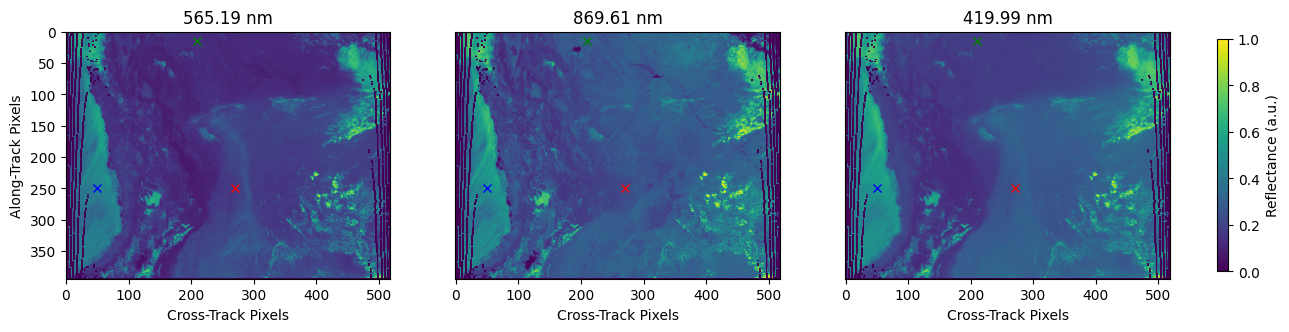

In [131]:
#set a reasonable scale based on images for radiance and DOLP, and the tilt index
rll,rul = 0,1
tilt = 0 #0 or 1. If the images are white, use the other tilt index.
select_targets = 1 #0 if you only want to plot the images, 1 if you want to see how good your estimation of target coordinates was.

#select targets in the images
if select_targets == 1:
    target_1 = [270,250]
    target_2 = [50,250]
    target_3 = [210,15]

#set up subfigures
fig, ax = plt.subplots(1,len(loc_wvl),figsize=(15,4))
for hcnt,h in enumerate(loc_wvl):

  #radiance
  im = ax[hcnt].imshow(rdnc[:,:,tilt,h],clim = [rll,rul])
  ax[hcnt].set_title(f"{name_wvl[hcnt]:.2f} nm")

  #plot target pixels
  if select_targets == 1:
      ax[hcnt].plot(target_1[0],target_1[1],'rx')
      ax[hcnt].plot(target_2[0],target_2[1],'bx')
      ax[hcnt].plot(target_3[0],target_3[1],'gx')

  #plot visuals
  if hcnt == 0:
    ax[hcnt].set_ylabel("Along-Track Pixels")
  elif hcnt >= 1:
    ax[hcnt].set_yticks([])

  ax[hcnt].set_xlabel("Cross-Track Pixels")

fig.colorbar(im, ax=ax,fraction=0.01,pad=0.04,label = "Reflectance (a.u.)")
#plt.savefig(f"3-panel_different_wavelengths.png",dpi=200,bbox_inches='tight')

Let's generate red-green-blue images that are closer to our eye. Sometimes it is easier to pick out features when the colors are relatively exposed. 

**NOTE**: <i>This cell will only work if you choose three wavelengths in the cell two up from here.</i>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


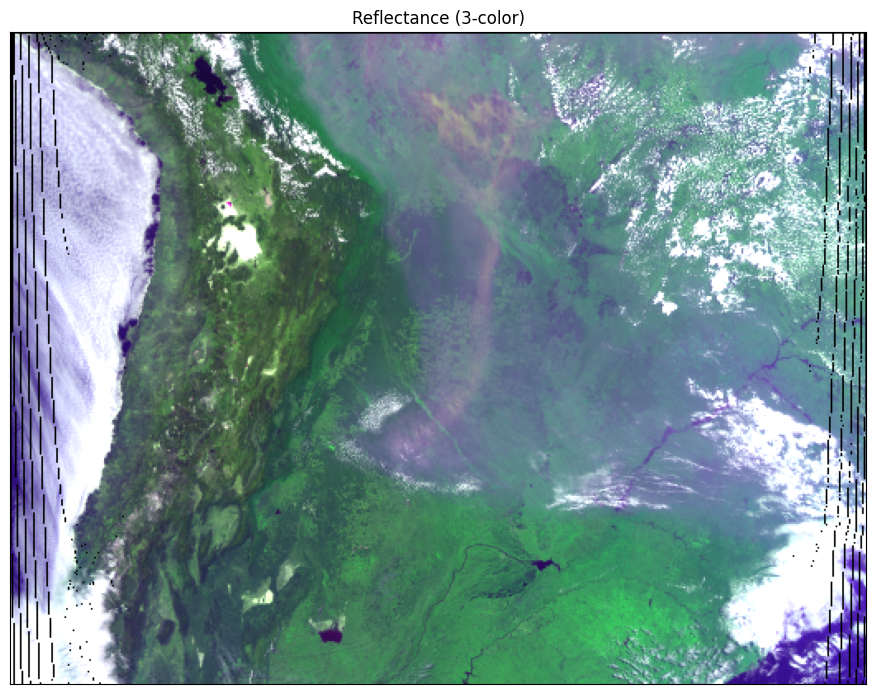

In [132]:
#this is a function that does some work for us. It cleans up the code a lot.
#this function will combine three color images together to make a composite.
def color3_make(ch1,ch2,ch3):
  '''
  INPUT
    ch1 - float array, data field
    ch2 - float array, data field
    ch3 - float array, data field
  OUTPUT
    stack - float array, normalized data stack [3x1]
  '''

  #find the maxima for each and use as a normalization
  ch1[ch1 < 0] = 0
  ch2[ch2 < 0] = 0 
  ch3[ch3 < 0] = 0
    
  stack = np.dstack([ch1/np.nanmax(ch1),ch2/np.nanmax(ch2),ch3/np.nanmax(ch3)])

  return stack

#allocate the nadir reflectances images for each
img1 = rdnc[:,:,tilt,loc_wvl[0]]
img2 = rdnc[:,:,tilt,loc_wvl[1]]
img3 = rdnc[:,:,tilt,loc_wvl[2]]

#may need to modify this value to make the image brighter
factor = 2
color3 = color3_make(img1,img2,img3)*factor

#plot the 3-color
plt.figure(figsize=(9,7))
plt.title("Reflectance (3-color)")
plt.imshow(np.flipud(color3))
plt.xticks([])
plt.yticks([])

plt.tight_layout()
#plt.savefig(f"RGB-style_3-panel_composite.png",dpi=200,bbox_inches='tight')

## Plot the spectra of a specific pixel in the image!
Let's write this code together.

Text(0, 0.5, 'Brightness Signal')

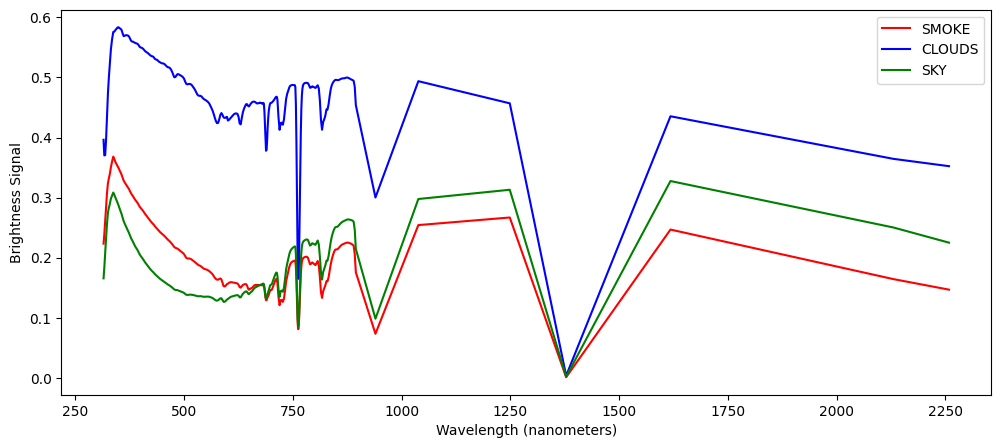

In [138]:
#recast the data into more consise variables
signal_1 = rdnc[target_1[1],target_1[0],tilt,:]
signal_2 = rdnc[target_2[1],target_2[0],tilt,:]
signal_3 = rdnc[target_3[1],target_3[0],tilt,:]

#plot different signal profiles with wavelength
plt.figure(figsize=(12,5))
plt.plot(chnl_by_view,signal_1,'r-')
plt.plot(chnl_by_view,signal_2,'b-')
plt.plot(chnl_by_view,signal_3,'g-')
plt.legend(["SMOKE","CLOUDS","SKY"])
plt.xlabel("Wavelength (nanometers)")
plt.ylabel("Brightness Signal")

#save the image
#plt.savefig(f"target_spectra.png",dpi=200,bbox_inches='tight')

## Projecting the Imagery onto the Earth's surface
This script will use the <i>cartopy</i> library, the latitude, longitude grids, and the RGB generated up there to put that data on the Earth's surface.

Text(0.5, 0, 'Longitude (degrees East)')

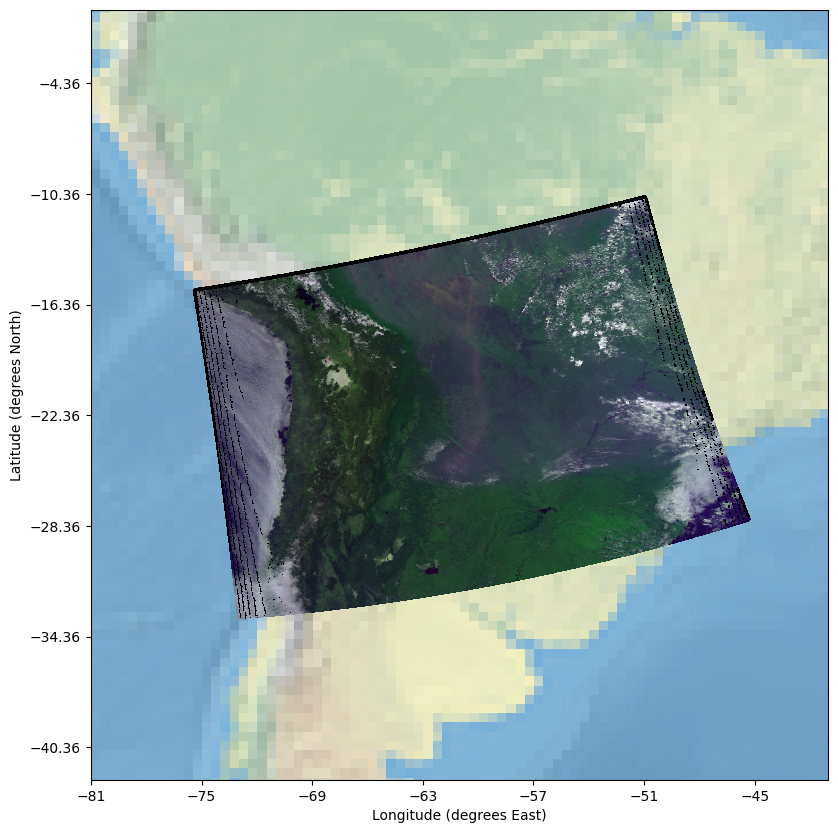

In [134]:
#pre-processing the RGB for projection
rgb = color3[:,:-1,:]/factor
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

#projection parameters (feel free to modify the bnd, offlon, offlat) as needed to get a good image
bnd, offlon, offlat = 20.,0.,2. #degrees
lon_l,lon_r,lat_d,lat_u = center_lon - bnd + offlon, center_lon + bnd + offlon, center_lat - bnd + offlat, center_lat + bnd + offlat

plt.figure(3,figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([lon_l,lon_r,lat_d,lat_u])

ax.set_xmargin(0.05)
ax.set_ymargin(0.10)

img = ax.pcolormesh(lon,lat,rgb,color=colorTuple,cmap=plt.cm.brg)
#ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_xticks(np.arange(np.round(lon_l,1),np.round(lon_r,1),6), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_d,lat_u,6), crs=ccrs.PlateCarree())
ax.set_ylabel("Latitude (degrees North)")
ax.set_xlabel("Longitude (degrees East)")  

## Special Codes for Specific Projects

----

### Land Project
This cell will calculate the Normalized Difference Vegetation Index (NDVI), which scientists have been using since the 1980s to track vegetation across the globe through the seasons. You will need to pick the two wavelengths that go into the derivation carefully, so that vegetation areas are easy to identify. Reference the class slides or look NDVI up online if you need a hint.

In [135]:
#wavelength(s) I would like (change this as needed)
wvls = [0,0] #nanometers

#for all the wavelengths you choose, we can calculate the locations in the list
loc_wvl,name_wvl = [],[]
for wvl_choice in wvls:
    
    #minimize the distance between the wavelength you want and all the others in the list
    min_dist = np.abs( np.array(chnl_by_view) - wvl_choice)
        
    #find the location of a specific wavelength in the list
    idx = np.where(min_dist == np.min(min_dist))[0][0]
    loc_wvl.append( idx )
    name_wvl.append( chnl_by_view[idx] )
    
print(f"The closest wavelength is in position {loc_wvl} in the list.\n")
print(f"This wavelength(s) is/are {name_wvl} nm.")

The closest wavelength is in position [np.int64(0), np.int64(0)] in the list.

This wavelength(s) is/are [np.float32(314.55), np.float32(314.55)] nm.


NDVI is a ratio of images. The equation is below.

$NDVI = \frac{S_{color_1} - S_{color_2}}{S_{color_1} + S_{color_2}}$

where color_1 and color_2 are two different wavelength, and S stands for signal. The values of NDVI are between -1 and 1.

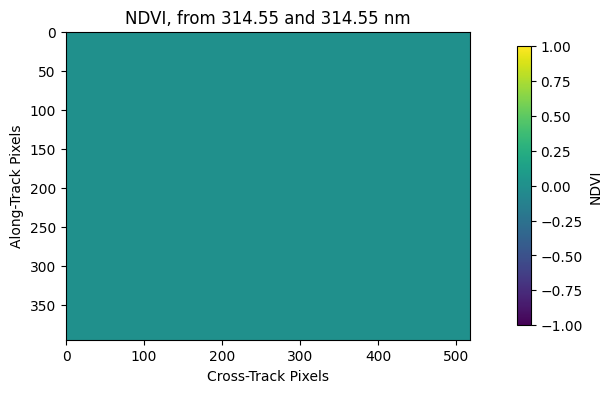

In [136]:
#set up subfigures and plot scale
plt.figure(figsize=(15,4))
rll,rul = -1,1

#calculate ndvi
color_1 = rdnc[:,:,tilt,loc_wvl[0]]
color_2 = rdnc[:,:,tilt,loc_wvl[1]]

ndvi = ( color_1 - color_2 )/( color_1 + color_2 )

#plot the ndvi
plt.imshow(np.flipud(ndvi),clim = [-1,1])
plt.title(f"NDVI, from {name_wvl[0]:.2f} and {name_wvl[1]:.2f} nm")

plt.ylabel("Along-Track Pixels")
plt.xlabel("Cross-Track Pixels")
plt.colorbar(fraction=0.012,pad=0.04,label = "NDVI")

#save the image
#plt.savefig(f"NDVI.png",dpi=200,bbox_inches='tight')